## Xception

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
from IPython.display import Image

In [98]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, \
                                    Dense, Flatten, Activation, GlobalAveragePooling2D, \
                                    Add, Resizing, MaxPooling2D, Dropout
from tensorflow.keras import Input, Model

### Convolution Batch-normalization block

In [3]:
def conv_bn(filters, kernel_size, strides=1, padding='valid', groups=1, name=None):
    def layer_fn(x):
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=padding,
                  groups=groups,
                  use_bias = False,
                  name=name)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x
    return layer_fn

## Simplified Inception module

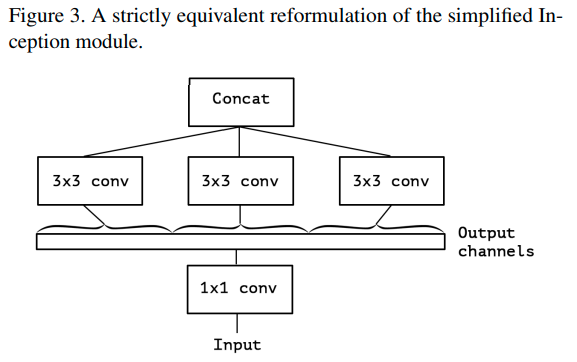

In [4]:
Image('image/xception_fig3.png')

In [5]:
def simplified_inception(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1))(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=3, name='3x3_conv')(x)
        return x
    return layer_fn

### Conv2D groups 테스트
* grouped_model 은 groups=3 설정으로 생성하고, ungrouped 은 groups=1 인 일반적인 Conv2D 로 생성했을 때 파라미터를 비교

In [6]:
def grouped_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = simplified_inception(32*3)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [7]:
def ungrouped_conv(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1))(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=1, name='3x3_conv')(x)
        return x
    return layer_fn

In [8]:
def ungrouped_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = ungrouped_conv(32*3)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [9]:
num_classes = 10
input_shape = [32, 32, 3]

batch_size = 16

In [10]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [11]:
model = grouped_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        288       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 3x3_conv (Conv2D)           (None, 32, 32, 96)        27648     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                             

In [12]:
model = ungrouped_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        288       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 32, 32, 96)        0         
                                                                 
 3x3_conv (Conv2D)           (None, 32, 32, 96)        82944     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                           

* ungrouped_model 의 3x3_conv 레이어의 파라미터 수는 82944
* grouped_model 의 3x3_conv 레이어의 파라미터 수는 27648

grouped_model 이 정확히 1/3 배의 파라미터수를 가지는 것으로 보아 3 개의 group 으로 정상적으로 작동함을 확인할 수 있었습니다. 

## Extreme version Inception module

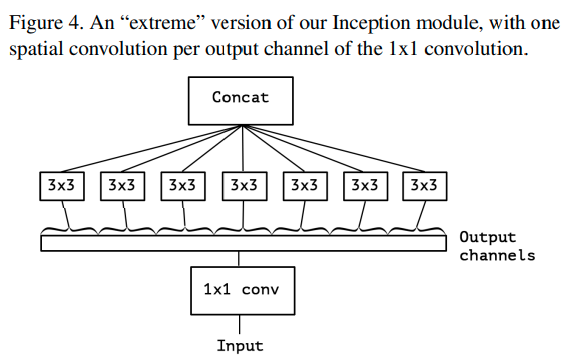

In [13]:
Image('image/xception_fig4.png')

In [14]:
def extreme_inception(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1), name='1x1_conv')(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=filters, name='extreme')(x)
        return x
    return layer_fn

In [15]:
def extreme_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = extreme_inception(32)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [16]:
num_classes = 10
input_shape = [32, 32, 3]

batch_size = 16

In [17]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [18]:
model = extreme_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 1x1_conv (Conv2D)           (None, 32, 32, 32)        96        
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 extreme (Conv2D)            (None, 32, 32, 32)        288       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                           

extreme 레이어의 파라미터 수 288 은

1개의 채널마다 3x3 conv 연산을 개별적으로 진행한 결과이므로

9(# of kernel param) * 32(# of in_channel) * 1(# of out_channel)

로 계산됩니다.

## Depth-wise Separable Convolution

In [19]:
def conv_separable(filters):
    def layer_fn(x):
        x = SeparableConv2D(filters=filters,
                           kernel_size=(3,3),
                           strides=1,
                           padding="same",
                           depth_multiplier=1,
                           use_bias=False,
                           name='separable_conv')(x)
        x = BatchNormalization()(x)
        return x
    return layer_fn

In [20]:
def separable_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = conv_separable(32)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [21]:
model = separable_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 separable_conv (SeparableCo  (None, 32, 32, 32)       123       
 nv2D)                                                           
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 output (Dense)              (None, 10)                327690    
                                                                 
Total params: 327,941
Trainable params: 327,877
Non-trainab

separable_conv 레이어의 파라미터 수 123 은

3x3 depthwise spatial convolution 연산 후

pointwise convolution 연산의 결과이므로

9(# of kernel param) * 3(# of in_channel) +
3(# of in_channel) * 1(# of kernel param) * 32(# of out_channel)

로 계산됩니다.

## Depth-wise Separable VS Extreme Inception
* 두 연산 모두 channel-wise spatial convolution 과 1x1 convolution 을 수행하지만 작동 순서가 다릅니다.
    * Depth-wise Separable : channel-wise conv -> 1x1 conv
    * Extreme Inception : 1x1 conv -> channel-wise conv
* 첫 연산 이후에 비선형성 존재에 따른 차이가 있습니다.
    * Depth-wise Separable : 첫 연산 이후에 비선형성을 위한 연산이 존재하지 않습니다.
    * Extreme Inception : 두 연산 뒤에는 항상 ReLU 비선형성이 따라옵니다.

# Xception architecture
* 주요 가정 : convolutional neural networks 의 feature map 에서 채널 간 상관 관계와 공간 상관 관계 매핑은 완전히 분리 가능하다.
* 이러한 가정을 기반으로 Xception 는 depth-wise separable convolution 을 사용하여 cross-channel conv과 spatial conv 를 독립적으로 계산하도록 고안되었습니다.

### 구현 포인트
    1. Xception 은 entry flow -> 8 * middle flow -> exit flow 로 이루어져 있습니다.
    2. 다이어그램에는 명시되어 있지 않지만 모든 Convolution 과 SeparableConvolution layer 의 뒤에는 batch normalization 이 따라옵니다.
    3. 모든 SeparableConvolution layer 의 depth multiplier 는 1로 설정되어 있습니다.(depth 증폭을 하지 않습니다)

In [142]:
import tensorflow.keras.regularizers as regularizers

In [143]:
num_classes = 1000
input_shape = [299, 299, 3]

batch_size = 8
num_epochs = 10

In [144]:
def convBn(filters, kernel_size, strides):
    def layer_fn(x):
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='valid',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.L2(1e-5),
                  use_bias=False)(x)
        x = BatchNormalization()(x)
        
        return x
    return layer_fn

In [145]:
def separableConv(filters, kernel_size, strides):
    def layer_fn(x):
        x = SeparableConv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding='same',
                       depthwise_initializer='he_normal',
                       pointwise_initializer='he_normal',
                       depthwise_regularizer=regularizers.L2(1e-5),
                       pointwise_regularizer=regularizers.L2(1e-5),
                       use_bias=False)(x)
        x = BatchNormalization()(x)
        
        return x
    return layer_fn

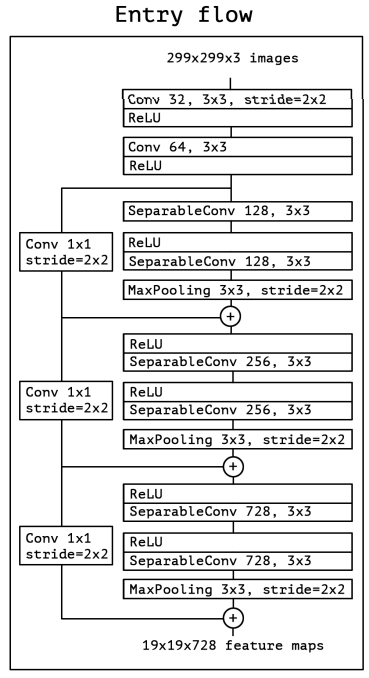

In [146]:
Image('image/xception_entry_flow.png')

In [147]:
def entry_flow(x):
    # 1 block
    x = convBn(filters=32, kernel_size=3, strides=2)(x)
    x = Activation('relu')(x)
    x = convBn(filters=64, kernel_size=3, strides=1)(x)
    x_1 = Activation('relu')(x)
    
    # 2 block
    x = separableConv(filters=128, kernel_size=3, strides=1)(x_1)
    x = Activation('relu')(x)
    x = separableConv(filters=128, kernel_size=3, strides=1)(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x_skip = convBn(filters=128, kernel_size=1, strides=2)(x_1)
    x_2 = Add()([x_skip, x])
    
    # 3 block
    x = Activation('relu')(x_2)
    x = separableConv(filters=256, kernel_size=3, strides=1)(x)
    x = Activation('relu')(x)
    x = separableConv(filters=256, kernel_size=3, strides=1)(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
     
    x_skip = convBn(filters=256, kernel_size=1, strides=2)(x_2)
    x_3 = Add()([x_skip, x])
    
    # 4 block
    x = Activation('relu')(x_3)
    x = separableConv(filters=728, kernel_size=3, strides=1)(x)
    x = Activation('relu')(x)
    x = separableConv(filters=728, kernel_size=3, strides=1)(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
     
    x_skip = convBn(filters=728, kernel_size=1, strides=2)(x_3)
    x = Add()([x_skip, x])
    
    return x

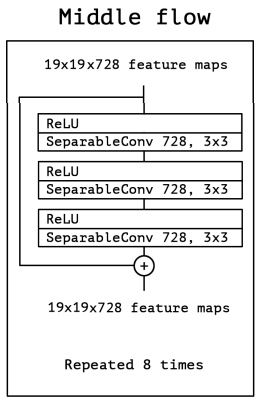

In [148]:
Image('image/xception_middle_flow.png')

In [149]:
def middle_flow(x_in):
    for _ in range(8):
        x = Activation('relu')(x_in)
        x = separableConv(filters=728, kernel_size=3, strides=1)(x)
        
        x = Activation('relu')(x)
        x = separableConv(filters=728, kernel_size=3, strides=1)(x)
        
        x = Activation('relu')(x)
        x = separableConv(filters=728, kernel_size=3, strides=1)(x)
        
        x_in = Add()([x_in, x])
    
    return x_in

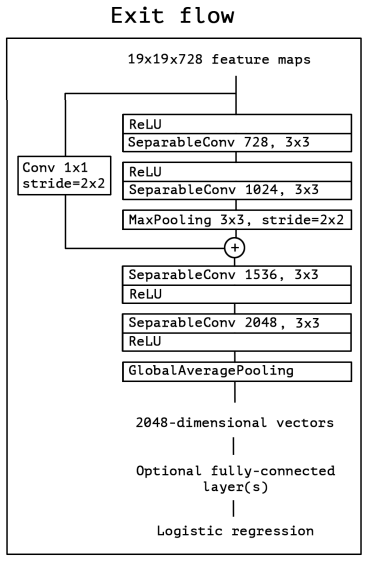

In [150]:
Image('image/xception_exit_flow.png')

In [151]:
def exit_flow(x_in, num_classes):
    x = Activation('relu')(x_in)
    x = separableConv(filters=728, kernel_size=3, strides=1)(x)
    x = Activation('relu')(x)
    x = separableConv(filters=1024, kernel_size=3, strides=1)(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x_skip = convBn(filters=1024, kernel_size=1, strides=2)(x_in)
    
    x = Add()([x_skip, x])
    
    x = separableConv(filters=1536, kernel_size=3, strides=1)(x)
    x = Activation('relu')(x)
    
    x = separableConv(filters=2048, kernel_size=3, strides=1)(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    
    # optional
    x = Dropout(0.5)(x)
    x = Dense(units=2048, 
              activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=regularizers.L2(1e-5))(x)
    
    x = Dropout(0.5)(x)
    x = Dense(units=num_classes, 
              activation='softmax',
              kernel_initializer='he_normal',
              kernel_regularizer=regularizers.L2(1e-5),
              name='output')(x)
    
    return x

In [152]:
def Xception(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = Resizing(height=299, width=299, interpolation="bilinear")(input)
    
    x = entry_flow(x)
    x = middle_flow(x)
    output = exit_flow(x, num_classes)
    
    model = Model(inputs=input, outputs=output)
    
    return model

In [153]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [154]:
model = Xception(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

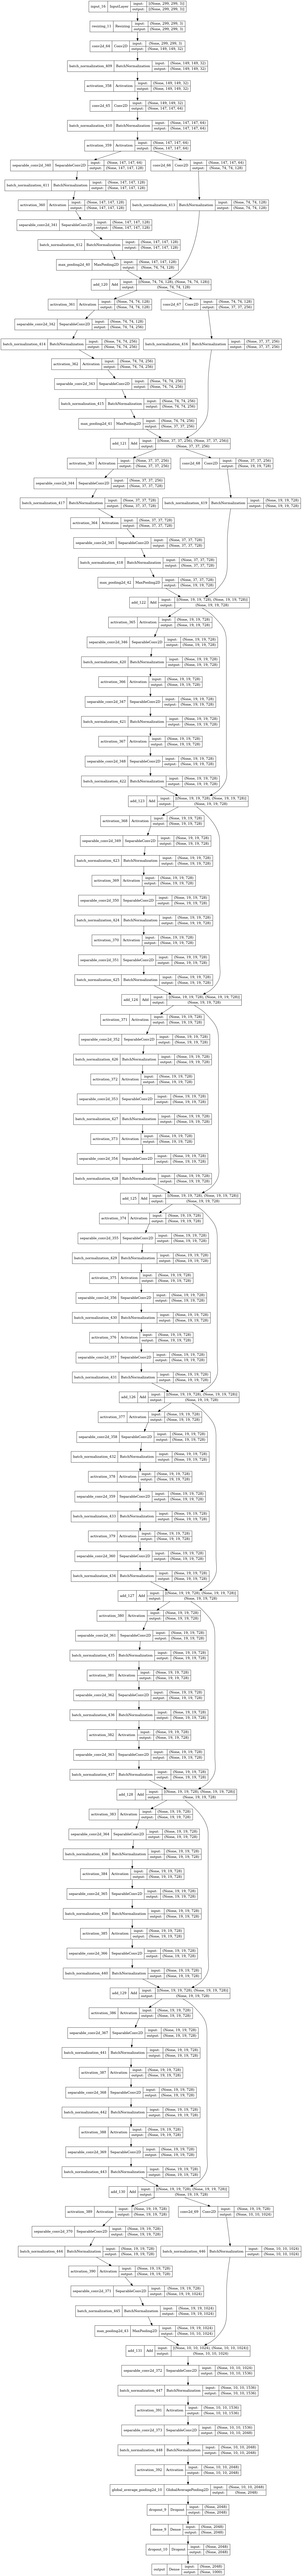

In [155]:
dot_img_file = 'Xception.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Training Example

In [156]:
input_shape = [71, 71, 3]
               
batch_size = 32
               
num_epochs = 10

In [157]:
def Xception_cifar10(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = Resizing(height=71, width=71, interpolation="bilinear")(input)
    
    x = entry_flow(x)
    x = middle_flow(x)
    output = exit_flow(x, num_classes)
    
    model = Model(inputs=input, outputs=output)
    
    return model

In [158]:
model = Xception_cifar10(input_shape, num_classes)

In [159]:
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
                                                                
model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[accuracy_metric, top5_accuracy_metric])

In [160]:
import os

model_dir = './models/xception_regularized'

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * 0.9
    else:
        return lr

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_acc',
                                    restore_best_weights=True),
    
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}.h5')),
]

### Training data load

In [161]:
import tensorflow_datasets as tfds

In [162]:
cifar_builder = tfds.builder("cifar10")
cifar_builder.download_and_prepare()

In [163]:
# Train/val Datasets:
train_dataset = cifar_builder.as_dataset(split=tfds.Split.TRAIN)
val_dataset = cifar_builder.as_dataset(split=tfds.Split.TEST)

# Number of classes:
num_classes = cifar_builder.info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_builder.info.splits['train'].num_examples
num_val_imgs = cifar_builder.info.splits['test'].num_examples

In [164]:
def _prepare_data_fn(features, input_shape, augment=False):
    
    input_shape = tf.convert_to_tensor(input_shape)
    
    image = features['image']
    label = features['label']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32) # 데이터 타입 변환, normalize 진행
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))

    return image, label

In [165]:
import functools

prepare_data_fn_for_train = functools.partial(_prepare_data_fn,
                                                input_shape=input_shape,
                                                augment=True)
prepare_data_fn_for_val = functools.partial(_prepare_data_fn,
                                            input_shape=input_shape,
                                            augment=False)

train_dataset = train_dataset.repeat(num_epochs) \
                        .shuffle(num_train_imgs) \
                        .map(prepare_data_fn_for_train, num_parallel_calls=4) \
                        .batch(batch_size) \
                        .prefetch(1)

val_dataset = val_dataset \
                    .repeat(num_epochs) \
                    .map(prepare_data_fn_for_val, num_parallel_calls=4) \
                    .batch(batch_size) \
                    .prefetch(1)

### Training

In [166]:
import math

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

regularized_history = model.fit(train_dataset,
                    epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                    validation_data=(val_dataset),
                    validation_steps=val_steps_per_epoch,
                    verbose=1, callbacks=callbacks)

Epoch 1/10
1563/1563 [==============================] - 120s 74ms/step - loss: 1.9640 - acc: 0.5050 - top5_acc: 0.9225 - val_loss: 1.9887 - val_acc: 0.5482 - val_top5_acc: 0.9363 - lr: 9.0000e-04oss: 2.0584 - acc: 0.4758 - top5_a - ETA: 20s - loss: 2.0539 - acc: 0.4775 - top5_ - ETA: 19s - loss: 2.0496 
Epoch 2/10
1563/1563 [==============================] - 117s 75ms/step - loss: 1.3170 - acc: 0.6949 - top5_acc: 0.9712 - val_loss: 1.7953 - val_acc: 0.5930 - val_top5_acc: 0.9217 - lr: 9.0000e-04
Epoch 3/10
1563/1563 [==============================] - 115s 73ms/step - loss: 0.9919 - acc: 0.7754 - top5_acc: 0.9836 - val_loss: 0.9979 - val_acc: 0.7688 - val_top5_acc: 0.9821 - lr: 8.1000e-04
Epoch 4/10
1563/1563 [==============================] - 116s 74ms/step - loss: 0.8207 - acc: 0.8196 - top5_acc: 0.9874 - val_loss: 0.9905 - val_acc: 0.7665 - val_top5_acc: 0.9826 - lr: 8.1000e-04
Epoch 5/10
1563/1563 [==============================] - 116s 74ms/step - loss: 0.6829 - acc: 0.8545 - top5_

1563/1563 [==============================] - 115s 74ms/step - loss: 0.3844 - acc: 0.9510 - top5_acc: 0.9990 - val_loss: 0.8848 - val_acc: 0.8258 - val_top5_acc: 0.9877 - lr: 5.9049e-04


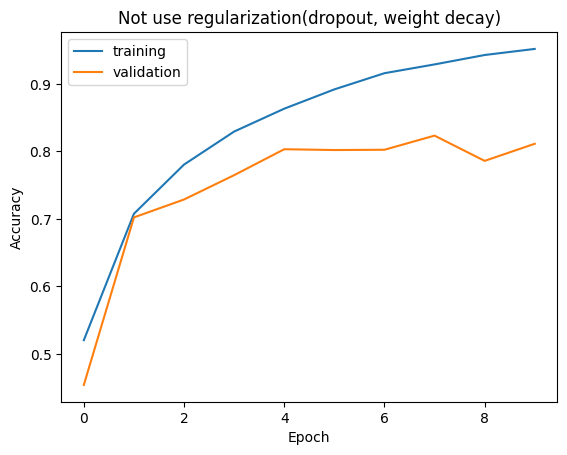

In [81]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Not use regularization(dropout, weight decay)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

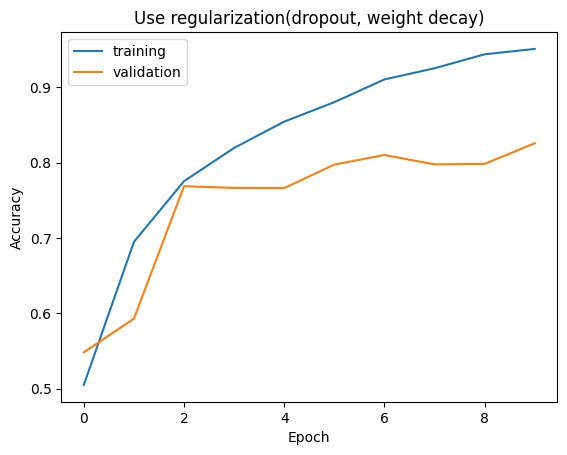

In [167]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(regularized_history.history['acc'])
plt.plot(regularized_history.history['val_acc'])
plt.title('Use regularization(dropout, weight decay)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

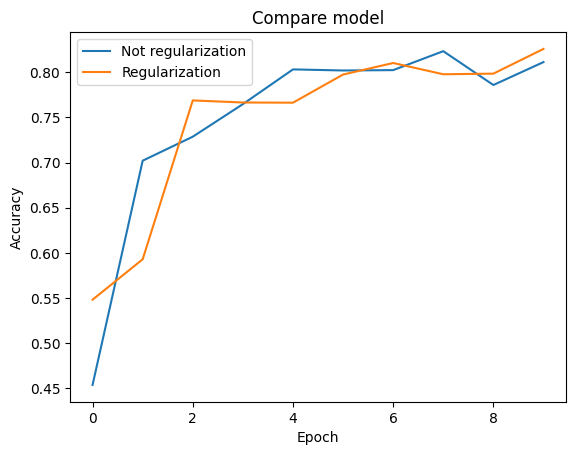

In [171]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_acc'])
plt.plot(regularized_history.history['val_acc'])
plt.title('Compare model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Not regularization', 'Regularization'], loc='upper left')
plt.show()